## Male and Female Classification

### Importing packages

In [165]:
import warnings
warnings.filterwarnings("ignore")
import os, cv2, random
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Populating the interactive namespace from numpy and matplotlib


### Preparing data

In [166]:
# loading labels for each image from csv
labels = pd.read_csv('results.csv')
labels = labels.iloc[:,0:2]
labels.head()

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
2,Raw_0003_003_20050913094955_Portrait.png,0
3,Raw_0005_004_20050913101316_Portrait.png,1
4,Raw_0007_005_20050913093707_Portrait.png,0


In [167]:
# Separating male labels
male_data = labels[labels['Gender'] == 0]
male_data.head()

,Filename,Gender
2,Raw_0003_003_20050913094955_Portrait.png,0
4,Raw_0007_005_20050913093707_Portrait.png,0
5,Raw_0009_006_20050913122608_Portrait.png,0
6,Raw_0010_007_20050913094809_Portrait.png,0
7,Raw_0011_008_20050913123954_Portrait.png,0


In [168]:
# Splitting male data into train and test
test_male_data = male_data.iloc[-3:,:]
train_male_data = male_data.iloc[:-3,:]

In [169]:
# Separating female labels
female_data = labels[labels['Gender'] == 1]
female_data.head()

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
3,Raw_0005_004_20050913101316_Portrait.png,1
9,Raw_0014_010_20050913093018_Portrait.png,1
22,Raw_0039_023_20050913110844_Portrait.png,1


In [170]:
# Splitting male data into train and test
test_female_data = female_data.iloc[-3:,:]
train_female_data = female_data.iloc[:-3,:]

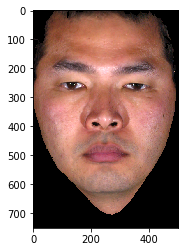

In [171]:
# Displaying one image to check
img=mpimg.imread('final/Raw_0016_011_20050913100034_Portrait.png')
imgplot = plt.imshow(img)
plt.show()

In [172]:
# total test data
test_indices = test_female_data.index.tolist() + test_male_data.index.tolist()
test_data = labels.iloc[test_indices,:]
test_data.head()

,Filename,Gender
100,Raw_0471_101_20050912225308_Portrait.png,1
108,Raw_0853_111_20050913155042_Portrait.png,1
111,Raw_0939_114_20050912231742_Portrait.png,1
113,Raw_1074_116_20050912184026_Portrait.png,0
114,Raw_1147_117_20050913192322_Portrait.png,0


In [173]:
# total train data
train_data = pd.concat([labels, test_data, test_data]).drop_duplicates(keep=False)
train_data.head()

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
2,Raw_0003_003_20050913094955_Portrait.png,0
3,Raw_0005_004_20050913101316_Portrait.png,1
4,Raw_0007_005_20050913093707_Portrait.png,0


In [174]:
# train and test with image name along with paths
path = '/home/shussain/Downloads/June/Gender Classification/final/'
train_image_name = [path+each for each in train_data['Filename'].values.tolist()]
test_image_name = [path+each for each in test_data['Filename'].values.tolist()]

In [175]:
# preparing data by processing images using opencv
ROWS = 64
COLS = 64
CHANNELS = 3

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%5 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_image_name)
test = prep_data(test_image_name)

Processed 0 of 110
Processed 5 of 110
Processed 10 of 110
Processed 15 of 110
Processed 20 of 110
Processed 25 of 110
Processed 30 of 110
Processed 35 of 110
Processed 40 of 110
Processed 45 of 110
Processed 50 of 110
Processed 55 of 110
Processed 60 of 110
Processed 65 of 110
Processed 70 of 110
Processed 75 of 110
Processed 80 of 110
Processed 85 of 110
Processed 90 of 110
Processed 95 of 110
Processed 100 of 110
Processed 105 of 110
Processed 0 of 6
Processed 5 of 6


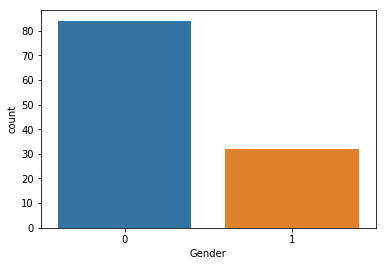

In [176]:
# checking count of male and females
sns.countplot(labels['Gender'])

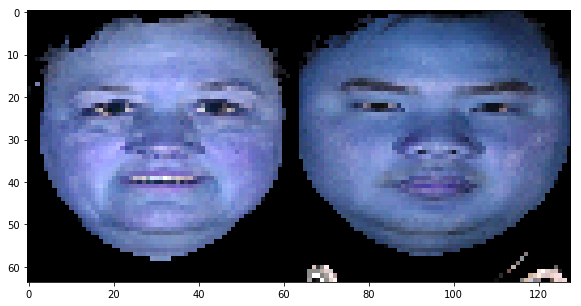

In [177]:
# plotting female and male side by side
def show_male_and_female():
    female = read_image(train_image_name[0])
    male = read_image(train_image_name[2])
    pair = np.concatenate((female, male), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
show_male_and_female()

In [178]:
# splitting path of all images into male and female
train_male_image = []
train_female_image = []
for each in train_image_name:
    if each.split('/')[7] in train_male_data['Filename'].values:
        train_male_image.append(each)
    else:
        train_female_image.append(each)

### Creating VGG 16 model for training it on male and female data

In [203]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def malefemale():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))



    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = malefemale()

In [204]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 3, 64, 32)         18464     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 3, 64, 32)         9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 3, 32, 16)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 3, 32, 64)         9280      
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 3, 32, 64)         36928     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 3, 16, 32)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 3, 16, 128)        36992     
__________

In [213]:
nb_epoch = 10
batch_size = 16
labs = train_data.iloc[:,1].values.tolist()

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
history = LossHistory()
model.fit(train, labs, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])

Epoch 00004: early stopping


In [214]:
predictions = model.predict(test, verbose=0)
predictions

array([[0.96050185],
       [0.78749096],
       [0.87002367],
       [0.30189696],
       [0.24755386],
       [0.01129169]], dtype=float32)

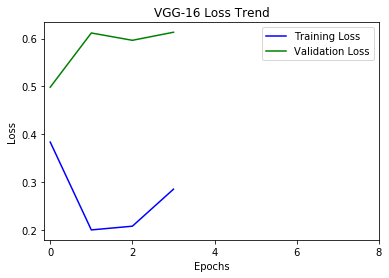

In [215]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

I am 96.05% sure this is a Female


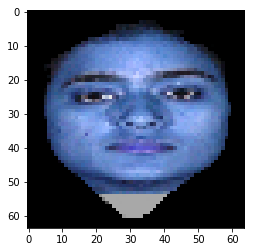

I am 78.75% sure this is a Female


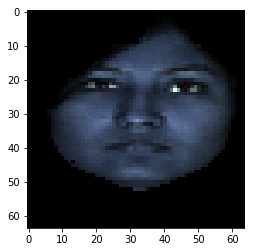

I am 87.00% sure this is a Female


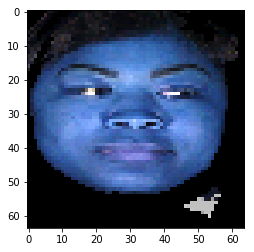

I am 69.81% sure this is a Male


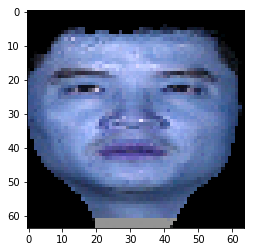

I am 75.24% sure this is a Male


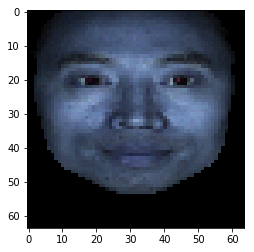

I am 98.87% sure this is a Male


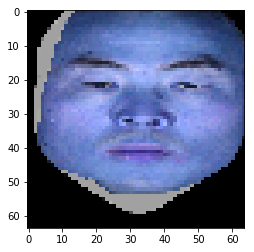

In [216]:
for i in range(0,6):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Female'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Male'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()